# CS5489 - Machine Learning
# Lecture 6a - Unsupervised Learning: Dimensionality Reduction
## Dr. Antoni B. Chan
### Dept. of Computer Science, City University of Hong Kong

# Supervised Learning
- *Supervised learning* considers input-output pairs $(\mathbf{x},y)$
  - learn a mapping from input to output.
  - *classification*: output $y \in \pm 1$
  - *regression*: output $y \in \mathbb{R}$
- "Supervised" here means that the algorithm is learning the mapping that we want.

# Unsupervised Learning
- Unsupervised learning only considers the input data $\mathbf{x}$.
  - There are no output values.
- **Goal:** Try to discover inherent properties in the data.
<table><tr><td>Clustering</td><td><img src="imgs/cluster.png" width=300></td></tr>
</table>

<table>
    <tr><td>Dimensionality Reduction</td><td><img src="imgs/pca.png" width=600></td></tr>
    <tr><td>Manifold Embedding</td><td><img src="imgs/isomap1.png" width=600></td></tr></table>

# Outline
1. **Linear Dimensionality Reduction for Vectors**
2. Linear Dimensionality Reduction for Text
3. Non-linear Dimensionality Reduction
4. Manifold Embedding

In [1]:
# setup
%matplotlib inline
import IPython.core.display         # setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D

# Dimensionality Reduction
- **Goal:** Transform high-dimensional vectors into low-dimensional vectors.
  - Dimensions in the low-dim data represent co-occuring features in high-dim data.
  - Dimensions in the low-dim data may have semantic meaning.
- **For example:** document analysis
  - high-dim: bag-of-word vectors of documents
  - low-dim: each dimension represents similarity to a topic.
<center><img src="imgs/topic.png" width=300px></center>

- **Example:** image analysis
  - approximate an image as a weighted combination of several basis images
  - represent the image as the weights.
<center><img src="imgs/eigenfaces.jpg" width="400px"></center>

# Reasons for Dimensionality Reduction
- Preprocessing - make the dataset easier to use
- Reduce computational cost of running machine learning algorithms
- Remove noise - convert to lower dimension, and then project back to high-dimension
- Make the results easier to understand (visualization)

# Linear Dimensionality Reduction
- Project the original data onto a lower-dimensional hyperplane (e.g., line, plane).
  - I.e, Move and rotate the coordinate axis of the data
- Represent the data with coordinates in the new component space.
<img src="imgs/pca.png" width="800px">

- Equivalently, approximate the data point $\mathbf{x}$ as a linear combination of basis vectors (components) in the original space.
  - original data point $\mathbf{x}\in\mathbb{R}^d$
  - approximation: $\hat{\mathbf{x}} = \sum_{j=1}^p w_j \mathbf{v}_j$
    - $\mathbf{v}_j\in\mathbb{R}^d$ is a basis vector and $w_j\in\mathbb{R}$ the corresponding weight.
  - the data point $\mathbf{x}$ is then represented its corresponding weights
    - $\mathbf{w} = [w_1,\cdots,w_P] \in \mathbb{R}^p$

- Several methods for linear dimensionality reduction.
- **Differences:**
  - goal (reconstruction vs classification)
  - unsupervised vs. supervised
  - constraints on the basis vectors and the weights.
  - reconstruction error criteria

# Principal Component Analysis (PCA)
- Unsupervised method
- **Goal:** preserve the variance of the data as much as possible
  - choose basis vectors along the maximum variance (longest extent) of the data.
  - the basis vectors are called _principal components_ (PC).

In [2]:
## Visualization  ###############################################################################################
def plot_ellipse(ax, musigma, color="k", lw=1):
    """
    Based on
    http://stackoverflow.com/questions/17952171/not-sure-how-to-fit-data-with-a-gaussian-python.
    """

    mu, sigma = musigma
    
    # Compute eigenvalues and associated eigenvectors
    vals, vecs = linalg.eigh(sigma)

    # Compute "tilt" of ellipse using first eigenvector
    x, y = vecs[:, 0]
    theta = degrees(arctan2(y, x))

    # Eigenvalues give length of ellipse along each eigenvector
    # plot 2 stdevs
    w, h = 2 * sqrt(vals) 

    #ax.tick_params(axis='both', which='major', labelsize=20)
    ellipse = matplotlib.patches.Ellipse(mu, w, h, theta, fill=False, color=color, lw=lw)  # color="k")
    ellipse.set_clip_box(ax.bbox)
    ellipse.set_alpha(1.0)
    ax.add_artist(ellipse) 

In [3]:
def plot_basis(X, vo, Xp=None, sp=None, showleg=True, Y=None, axbox1=None, axbox2=None, 
               recon=False, showellipse=False, legfont=9):
    if sp is None:
        sp = ((1,2,1), (1,2,2))
    cols = ['k','g']
    
    axh = [None, None]
    
    if Y is None:
        Y = zeros(len(X))
        mycmap = plt.get_cmap('bwr')
    else:
        mycmap = rbow
    
    Ls = []
    LL = []
    
    # normalize v
    v = vo.copy()
    numd = v.shape[0]
    for j in range(numd):
        v[j,:] /= linalg.norm(v[j,:])
        # flip direction if necessary
        if all(v[j,:] < 0):
            v[j,:] *= -1.0
        
    Xm = mean(X,axis=0)         # get mean
    if Xp is None:
        Xp = dot(X-Xm,v.T) # project data onto v
    
    axh[0] = plt.subplot(sp[0][0], sp[0][1], sp[0][2])
    # plot points
    if recon:
        XX = dot(Xp, v) + Xm
        plt.scatter(X[:,0], X[:,1], s=5, edgecolor='none', c=Y, cmap=mycmap, edgecolors='k', alpha=0.5)
        plt.scatter(XX[:,0], XX[:,1], s=5, edgecolor='none', c='r', edgecolors='k', )
    else:
        plt.scatter(X[:,0], X[:,1], s=5, edgecolor='none', c=Y, cmap=mycmap, edgecolors='k')
    if showellipse:
        uY = unique(Y)
        for myY in uY:
            myX = X[Y==myY,:]
            myCov = cov(myX, rowvar=False)
            myMu  = mean(myX, axis=0)
            myColor = (myY - amin(Y)) / (amax(Y)-amin(Y))
            plot_ellipse(plt.gca(), (myMu, 4*myCov), color=mycmap(myColor))
            tmp = plt.scatter(myMu[0], myMu[1], s=160, marker='X', edgecolor='k', color=mycmap(myColor), label='$\mu_{}$'.format(myY+1))
            Ls.append(tmp)
            LL.append('$\mu_{}$'.format(myY+1))
            
    if axbox1 is not None:
        plt.axis(axbox1)
    else:
        plt.axis('equal')
    plt.grid(True)
    if recon:
        plt.title('Original space ($\hat{x}$)')
    else:
        plt.title('Original space (x)')
    
    tmp = plt.xlim()
    hw = (tmp[1]-tmp[0])/30
    lw = hw/10
    
    mind = zeros(numd)
    maxd = zeros(numd)
    for j in range(numd):
        mind[j] = Xp[:,j].min()
        maxd[j] = Xp[:,j].max()
        
        ofact = 0.9
        Xm2 = Xm + v[j]*maxd[j]*ofact
        Xm1 = Xm + v[j]*mind[j]*ofact
        vl = v[j]*(maxd[j]-mind[j])*ofact        

        D = {'width':lw, 'head_width':hw, 
             'color':cols[j], 'length_includes_head':True}
        if recon:
            D['alpha'] = 0.2
        tmp = plt.arrow(Xm1[0], Xm1[1], vl[0], vl[1], **D)
        Ls.append(tmp)
        LL.append("PC "+str(j))

    plt.plot(Xm[0], Xm[1], 'ks')
    if showleg:
        plt.legend(Ls, LL, loc='lower right', fontsize=legfont)
        
    axh[1] = plt.subplot(sp[1][0], sp[1][1], sp[1][2])
    plt.arrow(mind[0]*ofact, 0, (maxd[0]-mind[0])*ofact, 0, width=lw, head_width=hw, color=cols[0])
    if numd == 2:
        plt.arrow(0, mind[1]*ofact, 0, (maxd[1]-mind[1])*ofact, width=lw, head_width=hw, color=cols[1])        
        plt.scatter(Xp[:,0], Xp[:,1], s=10, marker='+', c=Y, cmap=mycmap, edgecolors='k')
        plt.xlabel('w1')
        plt.ylabel('w2')
    else:
        plt.scatter(Xp[:,0], zeros(len(Xp)), s=10, marker='x', c=Y, cmap=mycmap, edgecolors='k')
        plt.xlabel('w')
        if showellipse:
            for myY in uY:
                myX = Xp[Y==myY,:]
                myCov = diag([var(myX), 0.001])
                myMu  = array([mean(myX), 0])
                myColor = (myY - amin(Y)) / (amax(Y)-amin(Y))
                plot_ellipse(plt.gca(), (myMu, 4*myCov), color=mycmap(myColor))
                plt.scatter(myMu[0], myMu[1], s=160, marker='X', edgecolor='k', color=mycmap(myColor), label='$m_{}$'.format(myY+1))
            plt.legend(fontsize=legfont)


    if axbox2 is not None:
        plt.axis(axbox2)
    else:
        plt.axis('equal')
    plt.grid(True)
    plt.title('Low-dim space (w)')
    
    return axh

In [4]:
# image showing blobs of dots and various directions of largest variance
random.seed(5230)
Xblob,Y = datasets.make_blobs(100,2,centers=[[2,1]],cluster_std=1)
tmp = random.normal(size=(2,2))+3.5*eye(2)
Xblob = dot(Xblob,tmp)

axbox1 = [-5, 20, -10, 15]
axbox2 = [-15, 15, -15, 15]

vfig = plt.figure(figsize=(10,6))
plot_basis(Xblob, array([[1, 0.0]]), sp=((2,3,1), (2,3,4)), showleg=False, axbox1=axbox1, axbox2=axbox2)
plot_basis(Xblob, array([[1, 0.5]]), sp=((2,3,2), (2,3,5)), showleg=False, axbox1=axbox1, axbox2=axbox2)
plot_basis(Xblob, array([[1.0, 1.0]]), sp=((2,3,3), (2,3,6)), showleg=False, axbox1=axbox1, axbox2=axbox2)
plt.tight_layout()
plt.close()

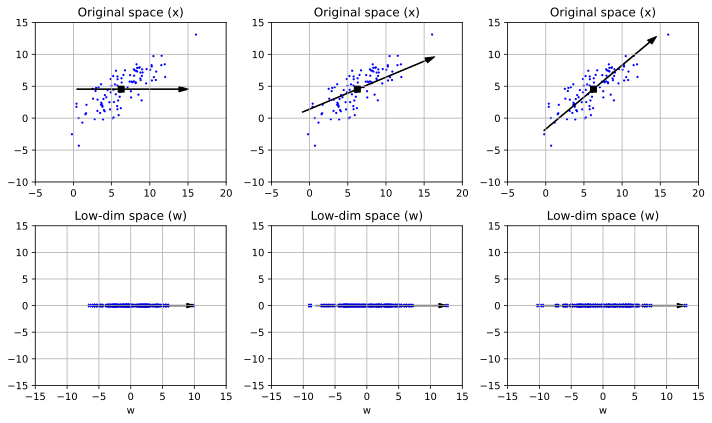

In [5]:
vfig

- **Goal:** Equivalently, minimize the reconstruction error over all the data points $\{\mathbf{x}_i\}_{i=1}^N$.
  - reconstruction: $\hat{\mathbf{x}}_i = \sum_{j=1}^p w_{i,j} \mathbf{v}_j$
  $$\min_{\mathbf{}w, \mathbf{v}} \sum_{i=1}^N ||\mathbf{x}_i - \hat{\mathbf{x}}_i||^2$$
  - _constraint:_ principal components $\mathbf{v}_j$ are orthogonal (perpendicular) to each other.
    - $\mathbf{v}_j^T\mathbf{v}_i = \begin{cases}1, i=j \\0, i\neq j\end{cases}$
  

# PCA algorithm

- Iteratively select directions that explain the most variance:
  - 1) subtract the mean of the data
  - 2) the first PC $\mathbf{v}_1$ is the direction that explains the most variance of the data.
  - 3) the second PC $\mathbf{v}_2$ is the direction perpendicular to $\mathbf{v}_1$ that explains the most variance.
  - 4) the third PC $\mathbf{v}_3$ is the direction perpendicular to $\{\mathbf{v}_1,\mathbf{v}_2\}$ that explains the most variance.
  - 5) ...


# Solution
- Define the mean-subtracted data as $\bar{\mathbf{x}}_i = \mathbf{x}_i - \mu$.
  - matrix of data $\bar{\mathbf{X}} = [\bar{\mathbf{x}}_1 \cdots \bar{\mathbf{x}}_N]$.
- Consider the covariance matrix of the data: $\Sigma = \frac{1}{N}\sum_i\bar{\mathbf{x}}_i\bar{\mathbf{x}}_i^T = \frac{1}{N}\bar{\mathbf{X}}\bar{\mathbf{X}}^T$
  - the covariance matrix defines ellipses of equal-probability of the Gaussian

In [6]:
X = Xblob
Mu    = mean(X, axis=0)
Sigma = cov(X, rowvar=False)

gfig = plt.figure()
plt.scatter(X[:,0], X[:,1], s=10)
plot_ellipse(plt.gca(), (Mu, Sigma), 'r')
plot_ellipse(plt.gca(), (Mu, 4*Sigma), 'r')
plt.plot(Mu[0], Mu[1], 'rx', label='mean')
plt.grid(True)
plt.axis('equal')
plt.close()

[[9.4987893  7.29218068]
 [7.29218068 8.74288433]]


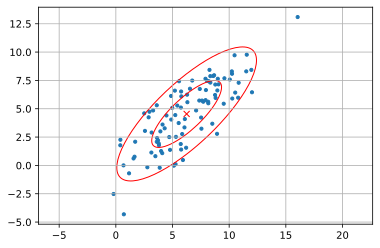

In [7]:
Sigma = cov(X, rowvar=False)
print(Sigma)
gfig

- Consider the eigenvectors and eigenvalues of $\Sigma$
  - i-th eigenvector/value pair: $\Sigma \mathbf{v}_i = \lambda_i \mathbf{v}_i$
  - all eigen-pairs: $\Sigma \mathbf{V} = \mathbf{V}\Lambda$
    - matrix of eigenvectors $\mathbf{V} = [\mathbf{v}_1 \cdots \mathbf{v}_D]$
    - eigenvectors are orthonormal: $\mathbf{V}^T\mathbf{V} = \mathbf{I}$
    - diagonal matrix of eigenvalues: $\Lambda = \mathrm{diag}([\lambda_1,\cdots,\lambda_D])$
  - **Eigendecomposition** of covariance: $\Sigma = \mathbf{V}\Lambda\mathbf{V}^T$
    - the eigenvector $\mathbf{v}_i$ is an axis of the ellipse.
    - the extent of axis $\mathbf{v}_i$ is related to the eigenvalue: $\sqrt{\lambda_i}$

In [8]:
[L,V] = linalg.eig(Sigma)
gfig = plt.figure()
plt.scatter(X[:,0], X[:,1], s=10)
plot_ellipse(plt.gca(), (Mu, Sigma), 'r')
plot_ellipse(plt.gca(), (Mu, 4*Sigma), 'r')
plt.plot(Mu[0], Mu[1], 'rx', label='mean')

E1 = 2*sqrt(L[0])*V[:,0]
E2 = 2*sqrt(L[1])*V[:,1]
plt.arrow(Mu[0], Mu[1], E1[0], E1[1], width=0.2, color='k', length_includes_head=True)
plt.text(Mu[0]+E1[0], Mu[1]+E1[1], '$2\sqrt{\lambda_1}\mathbf{v}_1$')
plt.arrow(Mu[0], Mu[1], E2[0], E2[1], width=0.2, color='g', length_includes_head=True)
plt.text(Mu[0]+E2[0]-4, Mu[1]+E2[1], '$2\sqrt{\lambda_2}\mathbf{v}_2$', )
plt.grid(True)
plt.axis('equal')
plt.close()
#plt.axis(axboxb)
#plt.close()

lambda =  [16.42280553  1.8188681 ]
v1 =  [0.72517596 0.68856359]
v2 =  [-0.68856359  0.72517596]


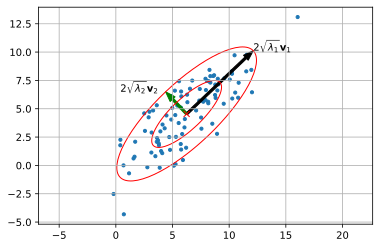

In [9]:
[L,V] = linalg.eig(Sigma)
print("lambda = ", L)
print("v1 = ", V[:,0])
print("v2 = ", V[:,1])
gfig

- Thus the solution to PCA is to select the eigenvectors with largest eigenvalues first.

- To reduce to $K$ dimensions
  - 1) subtract the mean of the data
  - 2) compute the covariance matrix $\Sigma$ of the data.
  - 3) sort the eigenvector/values of $\Sigma$ by $\lambda_1 > \lambda_2 > \cdots > \lambda_d$
  - 4) select the top $K$ eigenvectors: $\mathbf{V} = [\mathbf{v}_1 \cdots  \mathbf{v}_K]$
  - 5) project the data onto the PCA basis: $\mathbf{w}_i = \mathbf{V}^T \mathbf{x}_i \in \mathbb{R}^K$

- Reconstruction: $\hat{\mathbf{x}}_i = \mathbf{V}\mathbf{w}_i$

# Example - 1 PC

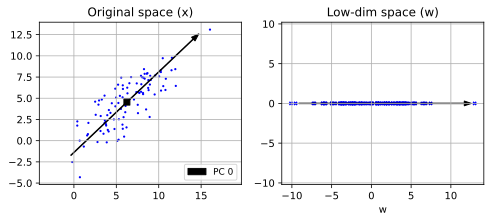

In [10]:
X = Xblob

# run PCA
pca = decomposition.PCA(n_components=1)
W   = pca.fit_transform(X)  # returns the coefficients

v = pca.components_  # the principal component vector
m = pca.mean_        # the data mean

plt.figure(figsize=(8,3))
plot_basis(X, v);

# Example - 1 PC reconstruction
- reconstucted $\mathbf{x}_i$ are projected onto the PC

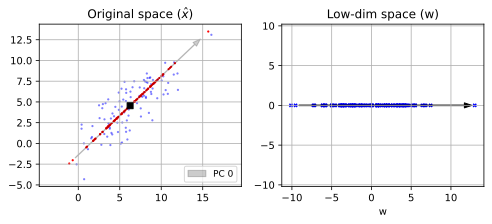

In [11]:
plt.figure(figsize=(8,3))
plot_basis(X, v, recon=True);

# Example - 2 PC

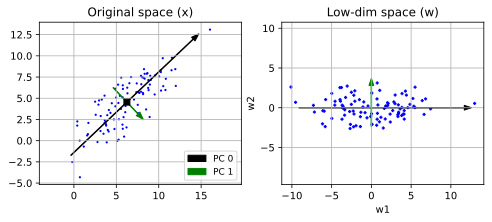

In [12]:
# run PCA
pca = decomposition.PCA(n_components=2)
W   = pca.fit_transform(X)

v = pca.components_  # the principal component vector
m = pca.mean_        # the data mean

plt.figure(figsize=(8,3))
plot_basis(X, v);

# Example on Iris data
- 2D (petal length, sepal width) to 1D

In [13]:
# example on Iris
axbox = [0, 8, 1.5, 5]

rbow = plt.get_cmap('rainbow')


# load iris data each row is (petal length, sepal width, class)
irisdata = loadtxt('iris3.csv', delimiter=',', skiprows=1)

Xiris = irisdata[:,0:2]  # the first two columns are features (petal length, sepal width)
Yiris = irisdata[:,2]    # the third column is the class label (setosa=0, versicolor=1, virginica=2)

X = Xiris
Y = Yiris

pca = decomposition.PCA(n_components=1)
W = pca.fit_transform(X)

ifig = plt.figure(figsize=(8,3))
axp = plot_basis(X, pca.components_)
plt.sca(axp[0])
plt.xlabel('petal length')
plt.ylabel('sepal width')
plt.close()

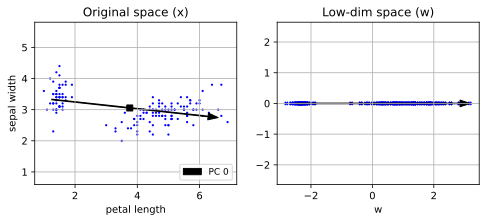

In [14]:
ifig

- 4D to 2D
- mostly preserves the structure of the classes.

In [15]:
# get data
iris = datasets.load_iris()
X = iris.data
Y = iris.target

# run PCA
pca = decomposition.PCA(n_components=2)
W = pca.fit_transform(X)
print(iris.feature_names)
print(pca.components_)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
[[ 0.36138659 -0.08452251  0.85667061  0.3582892 ]
 [ 0.65658877  0.73016143 -0.17337266 -0.07548102]]


In [16]:
i4fig = plt.figure()
plt.scatter(W[:,0], W[:,1], c=Y, cmap=rbow, edgecolors='k')
plt.axis('equal'); plt.grid(True)
plt.xlabel('PC1'); plt.ylabel('PC2');
plt.close()

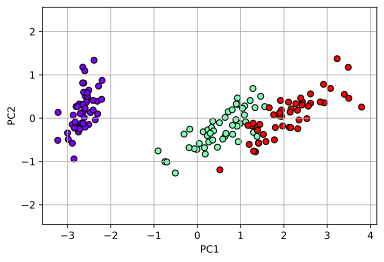

In [17]:
i4fig

# How to choose the number of principal components?
- Two methods to set the number of components $p$:
  - preserve some percentage of the variance (e.g., 95%).
  - whatever works well for our final task (e.g., classification, regression).


# Handwritten digits data
- 1797 images of handwritten digits 0-9
  - each image is 8x8
  - flattened into a 64 dimensional vector

In [18]:
# get digit data
digits = datasets.load_digits()
Xdigits = float64(digits.data)
Ydigits = digits.target

print(Xdigits.shape)

(1797, 64)


In [19]:
def show_array_as_imgs(X, imgsize, plotwidth, titles=None, Xmask=None, vmms=None, cmaps=None):
    "show each row of array X as an image"

    if X.ndim == 1:
        numX = 1
    else:
        numX = X.shape[0]
        
    height = int(ceil(numX/plotwidth))
    for n in range(numX):
        if (Xmask is None) or (Xmask[n]):
            plt.subplot(height,plotwidth,n+1)
            if numX > 1:
                I = X[n].reshape(imgsize)
            else:
                I = X.reshape(imgsize)
                
            D = {}
            if vmms is not None:
                D['vmin'] = vmms[n][0]
                D['vmax'] = vmms[n][1]
            if cmaps is not None:
                D['cmap'] = cmaps[n]
            plt.imshow(I, interpolation='nearest', **D)
            if cmaps is None:
                plt.gray()
            if titles is not None:
                plt.title(str(titles[n]))
            plt.gca().xaxis.set_ticklabels([])
            plt.gca().yaxis.set_ticklabels([])

imgsize = (8,8)
# show examples
dfig = plt.figure(figsize=(8,3.5))
myi = range(0,1797,190)
vmin = amin(Xdigits)
vmax = amax(Xdigits)
show_array_as_imgs(Xdigits[myi], imgsize, 5, Ydigits[myi], vmms=[(vmin,vmax)]*len(myi))
plt.close()

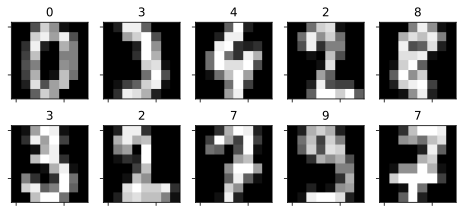

In [20]:
dfig

# Run PCA on the data
- split data into training and testing sets.
- run PCA on training set, apply to test set

In [21]:
# randomly split data into 80% train and 20% test set
trainX, testX, trainY, testY = \
  model_selection.train_test_split(Xdigits, Ydigits, 
  train_size=0.5, test_size=0.5, random_state=4487)
Xdim = Xdigits.shape[1]

# run PCA
pca = decomposition.PCA() # default: n_components=dimension
W  = pca.fit_transform(trainX)  # fit the training set
Wt = pca.transform(testX)  # use the pca model to transform the test set

- Visualize the coefficients for the first two PCs.
  - grouping of different digits is sometimes preserved

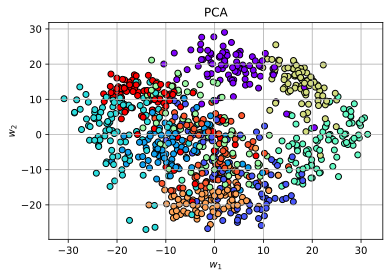

In [22]:
plt.figure()
plt.scatter(W[:,0], W[:,1], c=trainY, cmap=rbow, edgecolors='k')
plt.xlabel('$w_1$'); plt.ylabel('$w_2$')
plt.title('PCA'); plt.grid(True);

- Look at the mean and principal components

In [23]:
# plot the mean and the PCs
pcfig = plt.figure(figsize=(8,8))

tmpX = vstack((pca.mean_, pca.components_[range(24)]))
tmpT = ['mean']
for j in range(24):
    tmpT.append("PC " + str(j+1))

show_array_as_imgs(tmpX, imgsize, 5, tmpT)
plt.tight_layout()
plt.close()

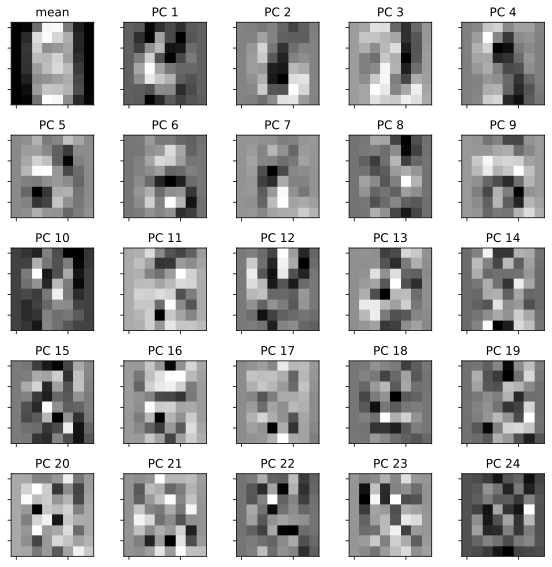

In [24]:
pcfig

- Reconstruction of a digit image from PC coefficients
  - red/green corresponds to postive/negative values
  - using more PCs will make the reconstruction better

In [25]:
myX = trainX[0]
myW = W[0]
nump = 6

myR = zeros( (3*(nump+1), 64) )
myR[0] = myX
myT = ['Original', None, None]
Xmask = [True, False, False]
vmms = [(vmin,vmax), None, None]

bwrcmap = matplotlib.colors.LinearSegmentedColormap.from_list('gkr', colors=['g', 'k', 'r'])
gcmap = plt.get_cmap('gray')
mycmaps = [gcmap, None, None]

for i in range(nump):
    basei = (i+1)*3
    if i==0:
        myR[basei] = pca.mean_
        myT.append('mean')
        vmms.append((vmin,vmax))
        mycmaps.append(gcmap)
    else:
        # take from previous result
        myR[basei] = myR[basei-1]
        myT.append(myT[basei-1][2:])
        vmms.append((vmin,vmax))
        mycmaps.append(gcmap)

    
    # add PC
    myR[basei+1] = myW[i] * pca.components_[i]
    myT.append('+ w{}*PC{}'.format(i+1, i+1))
    vmms.append((-vmax/2,vmax/2))
    mycmaps.append(bwrcmap)

    # new recon
    myR[basei+2] = myR[basei+1] + myR[basei+0]
    myT.append('= Recon' + str(i+1))
    vmms.append((vmin,vmax))
    mycmaps.append(gcmap)
        
    Xmask.append(True); Xmask.append(True); Xmask.append(True)

reconfig = plt.figure(figsize=(8,15))
show_array_as_imgs(myR, imgsize, 3, myT, Xmask=Xmask, vmms=vmms, cmaps=mycmaps)
plt.close()

[  6.3225555   14.02802981 -13.20374264   3.42192754  -6.55493652
  17.31869321]


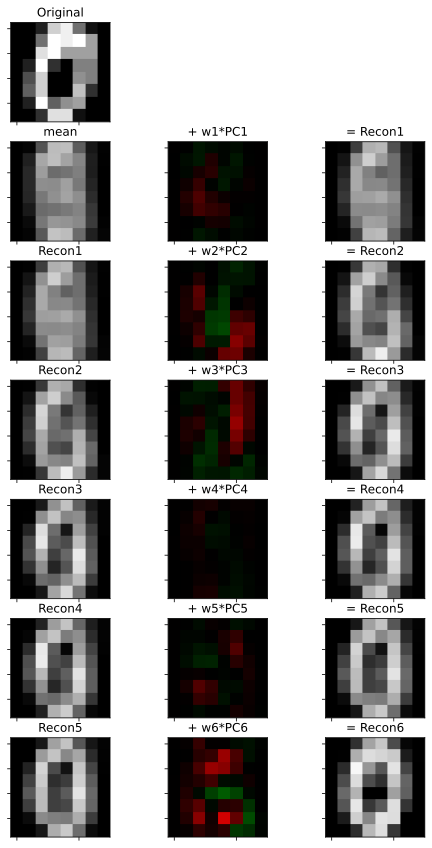

In [26]:
print(myW[0:6])
reconfig

# Explained variance
- each PC explains a percentage of the original data
  - this is called the _explained variance_.
  - PCs are already sorted by explained variance from highest to lowest
- pick the number of PCs to get a certain percentage of explained variance
  - typically 95%

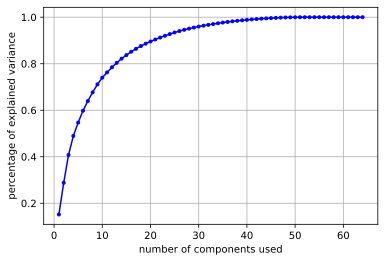

In [27]:
ev    = pca.explained_variance_ratio_  # variance explained by each component
cumev = cumsum(ev)                     # cumulative explained variance

plt.plot(range(1,Xdim+1), cumev, 'b.-')
plt.grid(True)
plt.xlabel('number of components used')
plt.ylabel('percentage of explained variance');

# Task-dependent Selection
- use results on the final task (in this case classification) to select the best number of components
- Note: we don't need to rerun PCA for each number of components
  - just select the subset of PCs based on the number of components desired.

In [28]:
acc = zeros(Xdim)
for j in range(Xdim):
    # extract the subset of PC weights [0,j]
    Wnew     = W[:,0:(j+1)]
    Wnewtest = Wt[:,0:(j+1)]
    
    # train classifier
    clf = svm.SVC(kernel='linear', C=1)
    clf.fit(Wnew, trainY)

    # test classifier
    Ypred = clf.predict(Wnewtest)    
    acc[j] = metrics.accuracy_score(testY, Ypred)

- classification accuracy is stable after using 20 PCs.
  - not much loss in performance if using only 20 PCs.

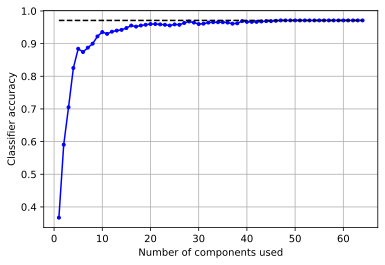

In [29]:
# make a plot
plt.plot(range(1,Xdim+1), acc, '.b-')
plt.plot([1,Xdim], [acc.max(), acc.max()], 'k--')
plt.grid(True)
plt.xlabel('Number of components used')
plt.ylabel('Classifier accuracy');

# Denoising
- the low-dim PCA space summarizes the important variations of the data.
- the original image can be denoised by:
  - 1) project into the low-dimensional space to get PCA coefficients
    - (keep only important variations)
  - 2) reconstruct an image from the PCA coefficients

In [30]:
# add noise to data
noisyX = trainX + 2*random.normal(size=trainX.shape)
noisyXt = testX + 2*random.normal(size=testX.shape)

# learn PCA
pca = decomposition.PCA(n_components=10)
pca.fit(noisyX)  # fit the training set

# transform and reconstuct
testW = pca.transform(noisyXt)
testXr = pca.inverse_transform(testW)   # reconstruction

In [31]:
myi = [0, 300, 500, 800, 801, 100, 200, 301, 401, 501]
tmpT = [""]*30
tmpT[0] = "original"
tmpT[10] = 'noisy'
tmpT[20] = "denoised"
rfig = plt.figure(figsize=(10,4))
show_array_as_imgs(array([*testX[myi], *noisyXt[myi], *testXr[myi]]), imgsize, 10, tmpT)
plt.close()

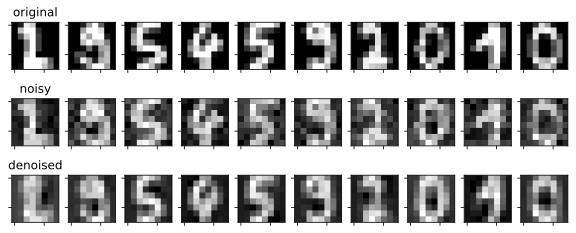

In [32]:
rfig

# Random Projections
- If the data is very high-dimensional, then it might take too many calculations to do PCA.
  - Complexity: $O(d k^2)$, $d$ is the dimension, $k$ is the number of components
- Do we really need to estimate the principal components to reduce the dimension?

- **Solution:**
  - We can generate random basis vectors and use those.
    - Each entry of $\mathbf{v}_j$ sampled from a Gaussian.
  - This will save a lot of time.
  - Random Projections can reduce computation at the expense of losing some accuracy in the points (adding noise).

In [33]:
# project the digits data with Random Projection
rp = random_projection.GaussianRandomProjection(n_components=2, random_state=4487)
Wrp = rp.fit_transform(trainX)

In [34]:
rfig = plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(W[:,0], W[:,1], c=trainY, cmap=rbow, edgecolors='k'); plt.grid(True)
plt.title('PCA')
plt.subplot(1,2,2)
plt.scatter(Wrp[:,0], Wrp[:,1], c=trainY, cmap=rbow, edgecolors='k'); plt.grid(True)
plt.title('Random Projection');
plt.close()

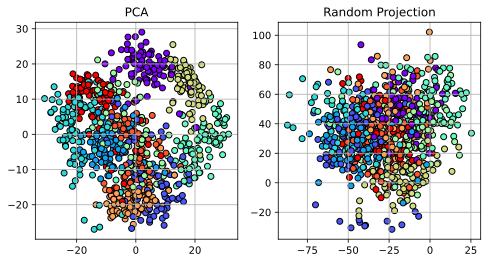

In [35]:
rfig

- Okay, but is it good?
  - One way to measure "goodness" is to see if the structure of the data is preserved.
  - In other words, are distances between points preserved in the transformed data?
<center><img src="imgs/rp.jpg" width=500></center>

- **Answer:**
  - Yes!
  - According to the *Johnson-Lindenstrauss lemma*, carefully selecting the distribution of the random projection matrices will preserve the pairwise distances between any two samples of the dataset, within some error _epsilon_.
    - $ (1-\epsilon)\| \mathbf{x}_i - \mathbf{x}_j\|^2 < \|\mathbf{w}_i - \mathbf{w}_j\|^2 < (1+\epsilon) \| \mathbf{x}_i - \mathbf{x}_j\|^2$

In [36]:
jlfig = plt.figure()
ns = 10**arange(1,7)
epss = arange(0.01, 1.00, 0.01)
for n in ns:
    mn = random_projection.johnson_lindenstrauss_min_dim(n_samples=n, eps=epss)
    plt.semilogy(epss, mn, label=str(n)+" samples")
plt.grid(True)
plt.xlabel('eps')
plt.ylabel('minimum number of reduced dimensions')
plt.legend(fontsize=9)
plt.close()

- the minimum reduced dimension $p$ to gaurantee an $\epsilon$ error depends on the number of samples.
  - (actually, this is fairly conservative)

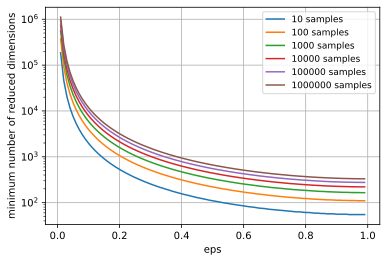

In [37]:
jlfig

- Example

In [38]:
# generate random data
# (dimension=10000, samples=100)
X = random.rand(100,10000)

# fit to 500 components
rp = random_projection.GaussianRandomProjection(n_components=500, random_state=4487)
Wrp = rp.fit_transform(X)

In [39]:
# Calculate the pairwise distances 
D = metrics.pairwise.euclidean_distances(X, X)
Drp = metrics.pairwise.euclidean_distances(Wrp, Wrp)

# calculate epsilon
epss = abs(Drp/D-1)
epss[isnan(epss)] = 0 # remove 0/0
efig = plt.figure()
plt.hist(epss.flatten())
plt.xlabel('epsilon')
plt.ylabel('count')
plt.grid(True)
plt.close()

/Users/abc/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


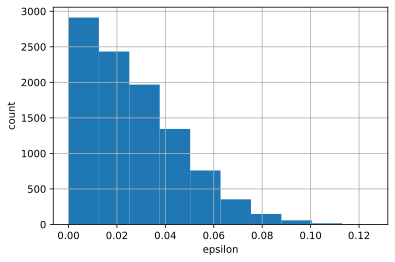

In [40]:
efig

# Sparse Random Projection
- More computation can be saved by using a _sparse_ random projection matrix
  - "sparse" means that many entries in the basis vector are zero, so we can ignore those entries when multiplying.

In [41]:
# project the digits data with Random Projection
srp = random_projection.SparseRandomProjection(n_components=500, random_state=4487)
Wsrp = srp.fit_transform(X)

In [44]:
# calculate pairwise distances
D = metrics.pairwise.euclidean_distances(X, X)
Dsrp = metrics.pairwise.euclidean_distances(Wsrp, Wsrp)

# calculate epsilon
epss = abs(Dsrp/D-1)
epss[isnan(epss)] = 0 # remove 0/0
efig = plt.figure(figsize=(6,4))
plt.hist(epss.flatten())
plt.xlabel('epsilon')
plt.ylabel('count')
plt.grid(True)
plt.close()

/Users/abc/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


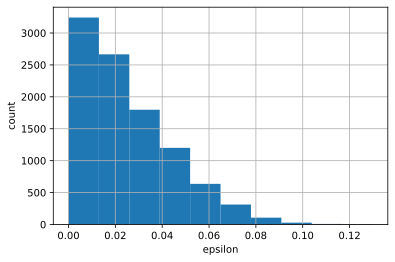

In [45]:
efig

# Question
- Suppose we have the below classification problem...
- We want to reduce the data to 1 dimension using PCA.
  - What is the first PC?

In [46]:
# example of PCA problem
random.seed(38)
Xbars,Ybars = datasets.make_blobs(300,2,centers=[[-5,0], [5,0]], cluster_std=0.8)
Xbars[:,0] /=8

X = Xbars
Y = Ybars

efig = plt.figure(figsize=(5,4))
plt.scatter(X[:,0], X[:,1], c=Y, cmap=rbow, s=5, edgecolor='none')
plt.axis('equal'); plt.grid(True)
plt.close()

e2fig = plt.figure(figsize=(8,4))
pca = decomposition.PCA(n_components=1)
W = pca.fit_transform(X)
plot_basis(X, pca.components_, Y=Y)
plt.close()

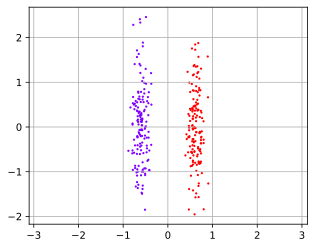

In [47]:
efig

# Answer
- first PC is along the direction of most variance.
  - collapses the two classes together!

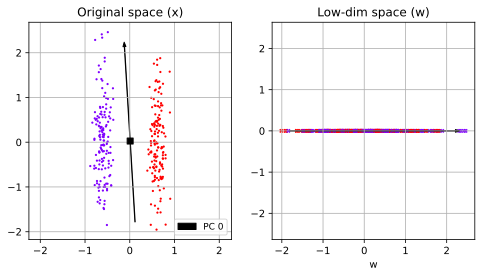

In [48]:
e2fig

# Problem with Unsupervised Methods
- If our end goal is classification, preserving the variance sometimes won't help!
  - PCA doesn't consider which class the data belongs to.
  - When the "classification" signal is less than the "noise", PCA will make classification more difficult.

# Fisher's Linear Discriminant (FLD)
- Supervised dimensionality reduction
- Also called _"Linear Discriminant Analysis"_ (LDA)
- **Goal:** find a lower-dim space so as to minimize the class overlap (or maximize the class separation).
  - data from each class is modeled as a Gaussian.
  - requires the class labels

# Problem setup
- Input space: class means $\mu_j$ and covariance (scatter) matrices $\mathbf{S}_j$.
- Projected space: class means $m_j = \mathbf{w}^T \mu_j$, and scatter $s_j = \mathbf{w}^T\mathbf{S}_j\mathbf{w}$  

In [49]:
lfig = plt.figure(figsize=(8,4))
plot_basis(X, array([[1.,.2]]), Y=Y, showellipse=True)
#plt.arrow(-1,-0.2,0.8,0, width=0.03, c=)
plt.annotate(text='', xy=(-1,-0.2), xytext=(-0.2,-0.2), arrowprops=dict(arrowstyle='<->', shrinkA=0, shrinkB=0))
plt.annotate(text='', xy=(0.25,-0.2), xytext=(1.,-0.2), arrowprops=dict(arrowstyle='<->', shrinkA=0, shrinkB=0))
plt.text(-0.65,-0.3,"$s_1$")
plt.text(0.6,-0.3,"$s_2$")
plt.close()

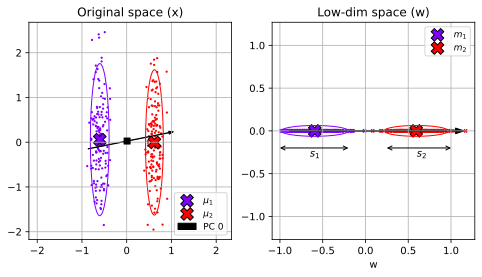

In [50]:
lfig

- **Idea:** make the projected points in each class as compact as possible
  - maximize the distance between the projected means
  - minimize the projected variances

In [51]:
efig = plt.figure(figsize=(10,5))
plot_basis(X, array([[0.,1.]]), Y=Y, showellipse=True, sp=((2,4,1), (2,4,5)), legfont=7)
plot_basis(X, array([[1.,1.]]), Y=Y, showellipse=True, sp=((2,4,2), (2,4,6)), legfont=7)
plot_basis(X, array([[1.,.2]]), Y=Y, showellipse=True, sp=((2,4,3), (2,4,7)), legfont=7)
plot_basis(X, array([[1.,0.]]), Y=Y, showellipse=True, sp=((2,4,4), (2,4,8)), legfont=7)
plt.tight_layout()
plt.close()

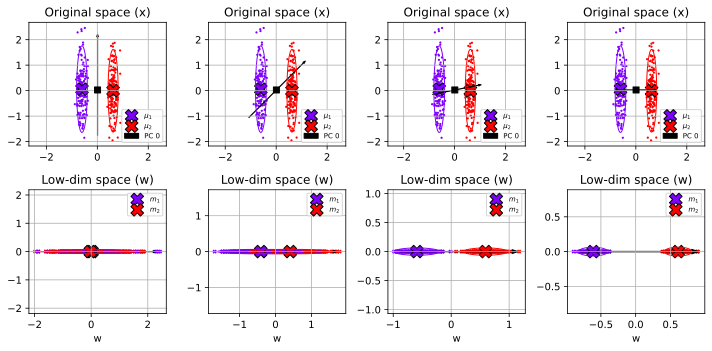

In [52]:
efig

- Fisher's linear discriminant (FLD)
  - Problem: $$\mathbf{w}^* = \mathop{\mathrm{argmax}}_{\mathbf{w}} \frac{(m_1-m_2)^2}{s_1+s_2}$$
  - Solution: $$\mathbf{w}^* = (\mathbf{S}_1+\mathbf{S}_2)^{-1}(\mu_1-\mu_2)$$

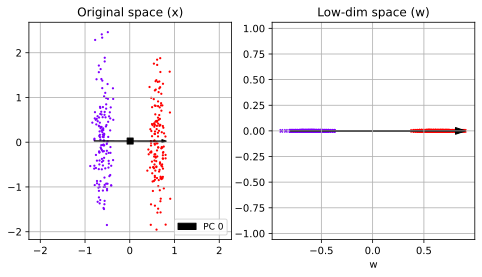

In [53]:
# example of FLD projection (using LDA name)
fld = discriminant_analysis.LinearDiscriminantAnalysis(n_components=1)
W  = fld.fit_transform(X, Y)

v = fld.coef_   # the basis vectors

plt.figure(figsize=(8,4))
plot_basis(X, v, Y=Y);

# On Iris data
- 4D vector to 2D vector
- FLD forms more compact classes
- With FLD, classes have less overlap if only using 1st basis vector.

In [54]:
# get data
X = iris.data  # 4D data
Y = iris.target

# run PCA
pca  = decomposition.PCA(n_components=2)
Wpca = pca.fit_transform(X)

# run LDA
fld   = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2)
Wfld  = fld.fit_transform(X, Y)

ifig = plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(Wpca[:,0], Wpca[:,1], c=Y, cmap=rbow, edgecolors='k')
plt.axis('equal'); plt.grid(True)
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title("PCA")
plt.subplot(1,2,2)
plt.scatter(Wfld[:,0], Wfld[:,1], c=Y, cmap=rbow, edgecolors='k')
plt.axis('equal'); plt.grid(True)
plt.xlabel('v1'); plt.ylabel('v2')
plt.title("FLD")
plt.close()

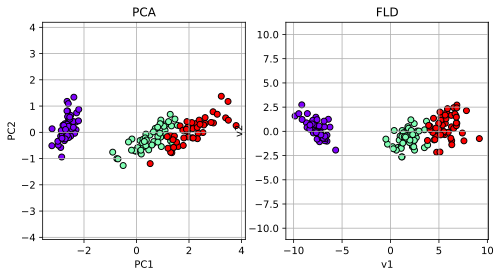

In [55]:
ifig